ThinCurr Python Example: Explicit model reduction {#doc_tCurr_reduction}
==========
In this example we demonstrate how to build a reduced model from a large ThinCurr model and apply that model to time-domain simulations.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) and [pyvista](https://pyvista.org/) python packages, which are installable using `pip` or other standard methods.

In [1]:
import struct
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pyvista
pyvista.set_jupyter_backend('static') # Comment to enable interactive PyVista plots
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load ThinCurr library

To load the ThinCurr python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` for binaries on macOS).

In [2]:
thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.sensor import Mirnov, save_sensors
from OpenFUSIONToolkit.util import build_XDMF, mu0
from OpenFUSIONToolkit.io import histfile

## Perform time-dependen simulation with full model

### Setup ThinCurr model
We now create a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance to use for equilibrium calculations. As this is a larger model, we use `nthreads=4` to increase the number of cores used for the calculation. Once created, we setup the model from an existing HDF5 and XML mesh definition using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()". We also initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html), [Paraview](https://www.paraview.org/), or using [pyvista](https://pyvista.org/) below.

In [3]:
tw_torus = ThinCurr(nthreads=4)
tw_torus.setup_model(mesh_file='thincurr_ex-ports.h5',xml_filename='oft_in.xml')
tw_torus.setup_io()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tCurr_red_model_improve
Revision id:          c73f0a2
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    4
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =       26500
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =        22580
  # of edges     =        67150
  # of cells     =        44560
  # of holes     =           11
  # of Vcoils    =            0
  # of closures  =            0
  # of Icoils    =            1

 

### Define some sensors

In [4]:
sensors = []
for i, theta in enumerate(np.linspace(0.0,2.0*np.pi/20.0,3)):
    sensors.append(Mirnov(1.6*np.r_[np.cos(theta),np.sin(theta),0.0], np.r_[0.0,0.0,1.0], 'Bz_{0}'.format(i+1)))
save_sensors(sensors)
Msensor, Msc, sensor_obj = tw_torus.compute_Msensor('floops.loc')


 Loading floop information:
   # of floops =           3
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix


### Compute inductance and resistivity matrices
With the model setup, we can now compute the self-inductance matrix using HODLR. When HODLR is used the result is a pointer to the Fortran operator, which is stored at \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.Lmat_hodlr "tw_torus.Lmat_hodlr". As in any other case, by default, the resistivity matrix is not moved to python as it is sparse and converting to dense representation would require an increase in memory. These matrices correspond to the $\textrm{L}$ and $\textrm{R}$ matrices for the physical system

$\textrm{L} \frac{\partial I}{\partial t} + \textrm{R} I = V$

**Note:** Even though HODLR should significantly accelerate the construction of the self-inductance matrix (see \ref doc_thincurr_ex4 for more information) this process may still take some time to complete.

**Note:** The non-zero savings achieved by HODLR compression is reported after the operator is built. Where in this case only 6% of the original memory is needed resulting in a reduction from > 3 GB to ~ 230 MB (over 10x smaller)!

In [5]:
Mc = tw_torus.compute_Mcoil()

 Building coil<->element inductance matrices
     Time =  0s          
 Building coil<->coil inductance matrix


In [6]:
tw_torus.compute_Lmat(use_hodlr=True,cache_file='HOLDR_L.save')

 Partitioning grid for block low rank compressed operators
   nBlocks =                  32
   Avg block size =          686
   # of SVD =                167
   # of ACA =                161

 Building block low rank inductance operator
   Building hole and Vcoil columns
   Reading HODLR matrix from file: HOLDR_L.save
   Building diagonal blocks
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
   Building off-diagonal blocks using ACA+
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
     Compression ratio:   6.1%  ( 2.94E+07/ 4.82E+08)
     Time =  6s          


In [7]:
tw_torus.compute_Rmat()

 Building resistivity matrix


### Compute eigenvalues/eigenvectors for the plate model
With $\textrm{L}$ and $\textrm{R}$ matrices we can now compute the eigenvalues and eigenvectors of the system $\textrm{L} I = \lambda \textrm{R} I$, where the eigenvalues $\lambda = \tau_{L/R}$ are the decay time-constants of the current distribution corresponding to each eigenvector.

In [8]:
eig_vals, eig_vecs = tw_torus.get_eigs(100,False)

 Starting eigenvalue solve
   Time =    3.2318799999999999     
 Eigenvalues
      3.8803532187707789E-002
      2.3122413609125238E-002
      2.3121320461447749E-002
      2.1444738359150221E-002
      2.0605568985419195E-002


## Run time-domain simulation

In [9]:
dt = 2.E-4
nsteps = 200
coil_currs = np.array([
    [0.0, 1.E6],
    [4.E-3, 0.0],
    [1.0, 0.0]
])
tw_torus.run_td(dt,nsteps,status_freq=10,coil_currs=coil_currs,sensor_obj=sensor_obj)


 Starting simulation
 Timestep           10   2.00000009E-03   22.7324543              32
 Timestep           20   4.00000019E-03   44.1192398              18
 Timestep           30   6.00000005E-03   42.2026939              32
 Timestep           40   8.00000038E-03   39.9049416              33
 Timestep           50   9.99999978E-03   37.7692757              32
 Timestep           60   1.20000001E-02   35.7698631              32
 Timestep           70   1.40000004E-02   33.8907814              32
 Timestep           80   1.60000008E-02   32.1206093              32
 Timestep           90   1.79999992E-02   30.4503746              32
 Timestep          100   1.99999996E-02   28.8726788              32
 Timestep          110   2.19999999E-02   27.3811474              32
 Timestep          120   2.40000002E-02   25.9701881              32
 Timestep          130   2.60000005E-02   24.6347980              32
 Timestep          140   2.80000009E-02   23.3704262              32
 Timestep   

### Compute B-field reconstruction operator

In [10]:
_, Bc = tw_torus.compute_Bmat(cache_file='HODLR_B.save')

 Building block low rank magnetic field operator
   Building hole and Vcoil columns
   Reading HODLR matrix from file: HODLR_B.save
   Building diagonal blocks
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
   Building off-diagonal blocks using ACA+
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
     Compression ratio:   7.1%  ( 1.05E+08/ 1.49E+09)
     Time =  7s          


### Generate plot files from run

In [11]:
tw_torus.plot_td(nsteps,compute_B=True,sensor_obj=sensor_obj)
tw_torus.build_XDMF()

 Post-processing simulation
Removing old Xdmf files
Creating output files


### Load sensor signals from time-domain run

In [12]:
hist_file = histfile('floops.hist')
print(hist_file)


OFT History file: floops.hist
  Number of fields = 4
  Number of entries = 201

  Fields:
    time: Simulation time [s] (d1)
    Bz_1: No description (d1)
    Bz_2: No description (d1)
    Bz_3: No description (d1)



### Build PyVista information for plotting

In [13]:
with h5py.File('mesh.0001.h5','r') as h5_file:
    r = np.asarray(h5_file['R_surf'])
    lc = np.asarray(h5_file['LC_surf'])
celltypes = np.array([pyvista.CellType.TRIANGLE for _ in range(lc.shape[0])], dtype=np.int8)
cells = np.insert(lc, [0,], 3, axis=1)
grid = pyvista.UnstructuredGrid(cells, celltypes, r)

# Explicit model reduction
In addition to HODLR, we can also explicitly reduce the model's size by projecting onto a fixed set of current strucutures using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.build_reduced_model "build_reduced_model()". In this case we use the 25 eigenvalues computed above, which will result in a system that reasonably matches slow dynamics with characterisitic times longer than the fastest eigenvalue.

**Note:** We have now reduced our system to only 160 KB from > 3 GB (over 18,000x smaller)! Assuming we are only interested in slow dynamics of course.

In [14]:
torus_reduced = tw_torus.build_reduced_model(eig_vecs, compute_B=True, sensor_obj=sensor_obj)

## Compute and compare eigenvalues
After building the reduced system was can compare the eigenvalues of the original system to show that the characteristic timescales are maintained.

In [15]:
eig_vals_r, eig_vecs_r = torus_reduced.get_eigs()
print("  {0:12} {1:12} ({2:8})".format("Reduced","Original","% Error"))
for i, eig_val in enumerate(eig_vals_r):
    if i == 5:
        print("  {0:12} {1:12} {2:10}".format(" ... "," ... "," ... "))
    elif (i > 5) and (i < eig_vals_r.shape[0]-2):
        continue
    print("{0:12.4E} {1:12.4E}   ({2:8.2E})".format(eig_val*1.E3,eig_vals[i]*1.E3,abs((eig_val-eig_vals[i])/eig_vals[i])))

  Reduced      Original     (% Error )
  3.8804E+01   3.8804E+01   (4.32E-09)
  2.3122E+01   2.3122E+01   (2.16E-09)
  2.3121E+01   2.3121E+01   (1.11E-09)
  2.1445E+01   2.1445E+01   (1.91E-08)
  2.0606E+01   2.0606E+01   (1.20E-09)
   ...          ...          ...      
  1.8735E+01   1.8735E+01   (4.89E-09)
  5.7417E+00   5.7417E+00   (3.01E-09)
  5.6741E+00   5.6741E+00   (2.50E-09)


### Compare current distributions
We can also plot the current distributions for the eigenmodes to show that they have the same structure as the original model.

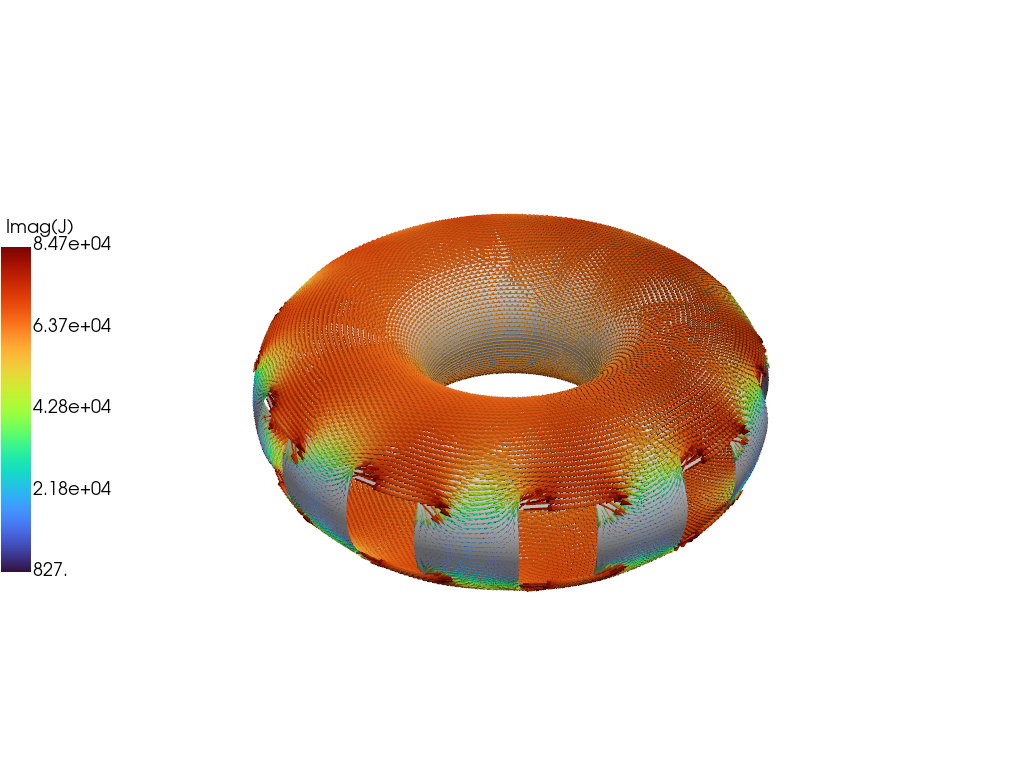

In [16]:
Jr_01 = tw_torus.reconstruct_current(torus_reduced.reconstruct_potential(eig_vecs_r[0,:]),centering='vertex')
grid["vectors"] = Jr_01
grid.set_active_vectors("vectors")
p = pyvista.Plotter()
scale = 0.2/(np.linalg.norm(Jr_01,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "Imag(J)", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.add_mesh(grid, color="white", opacity=1.0, show_edges=False)
p.show()

## Run time-dependent simulation


In [17]:
sensors, currents = torus_reduced.run_td(dt,nsteps,coil_currs)

Timestep 0   0.0000E+00   0.0000E+00
Timestep 10   2.0000E-03   3.1344E+00
Timestep 20   4.0000E-03   6.0592E+00
Timestep 30   6.0000E-03   5.7573E+00
Timestep 40   8.0000E-03   5.4154E+00
Timestep 50   1.0000E-02   5.1068E+00
Timestep 60   1.2000E-02   4.8245E+00
Timestep 70   1.4000E-02   4.5637E+00
Timestep 80   1.6000E-02   4.3210E+00
Timestep 90   1.8000E-02   4.0941E+00
Timestep 100   2.0000E-02   3.8811E+00
Timestep 110   2.2000E-02   3.6806E+00
Timestep 120   2.4000E-02   3.4915E+00
Timestep 130   2.6000E-02   3.3129E+00
Timestep 140   2.8000E-02   3.1440E+00
Timestep 150   3.0000E-02   2.9841E+00
Timestep 160   3.2000E-02   2.8327E+00
Timestep 170   3.4000E-02   2.6892E+00
Timestep 180   3.6000E-02   2.5531E+00
Timestep 190   3.8000E-02   2.4241E+00
Timestep 200   4.0000E-02   2.3017E+00


### Compare sensor signals
Now we compare the probe signals from full and reduced models, noting good agreement overall with some discrepancy early in time with the results converging at later times.

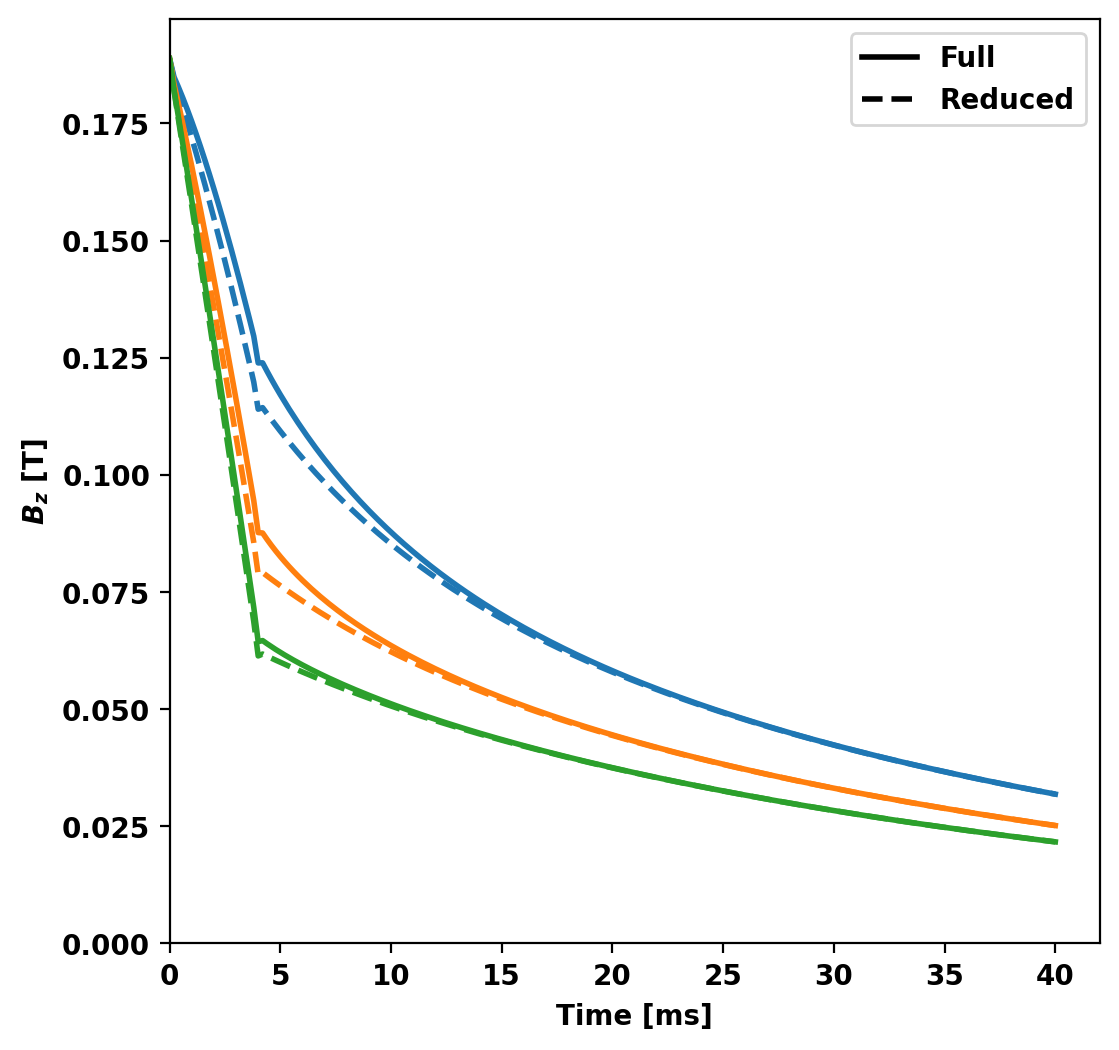

In [18]:
fig, ax = plt.subplots(1,1)
for i in range(sensors['sensors'].shape[1]):
    line, = ax.plot(hist_file['time']*1.E3,hist_file['Bz_{0}'.format(i+1)])
    ax.plot(sensors['time']*1.E3,sensors['sensors'][:,i],'--',color=line.get_color())
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0)
Full = mlines.Line2D([], [], color='k', linestyle='-',label='Full')
Reduced = mlines.Line2D([], [], color='k', linestyle='--',label='Reduced')
ax.legend(handles=[Full, Reduced])
ax.set_xlabel('Time [ms]')
_ =ax.set_ylabel(r'$B_z$ [T]')

### Compare current distribution
We can plot the current distributions for the eigenmodes to show that they have nearly the same structure and time-dependence as the full model.
Below comparison is performed at $t = 20$ ms showing good agreement, which should only improve at later times.

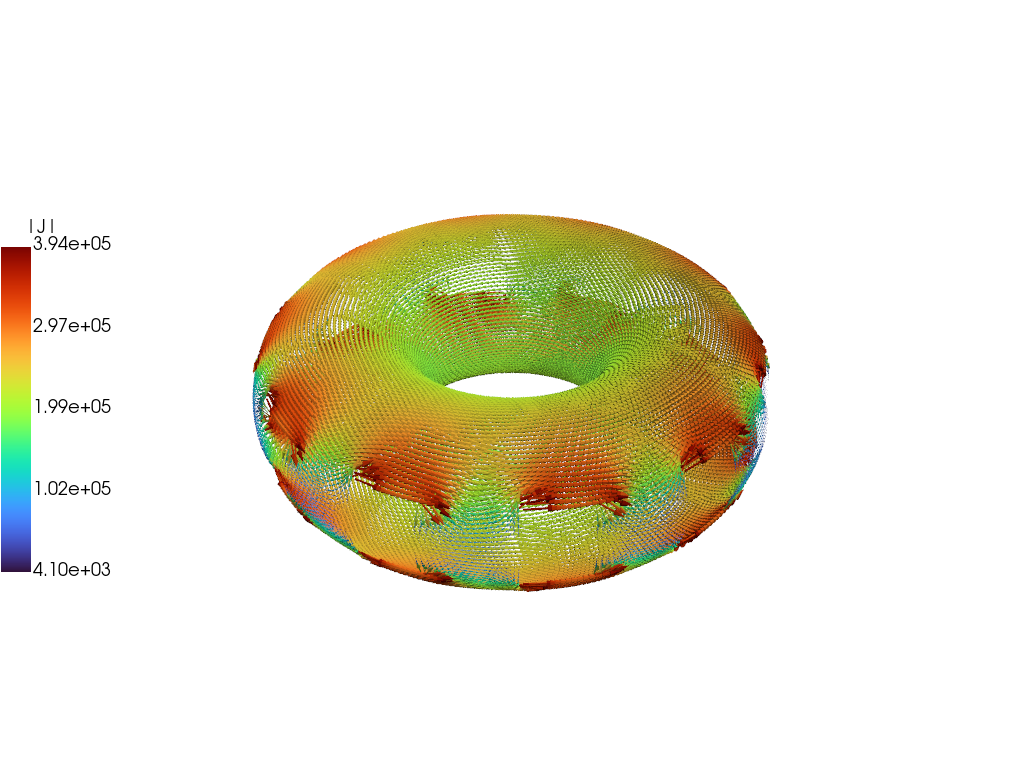

In [19]:
with h5py.File('vector_dump.0001.h5','r') as h5_file:
    Jfull = np.asarray(h5_file['J_v0011'])
#
grid["vectors"] = Jfull
grid.set_active_vectors("vectors")
p = pyvista.Plotter()
scale = 0.2/(np.linalg.norm(Jfull,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "|J|", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.show()

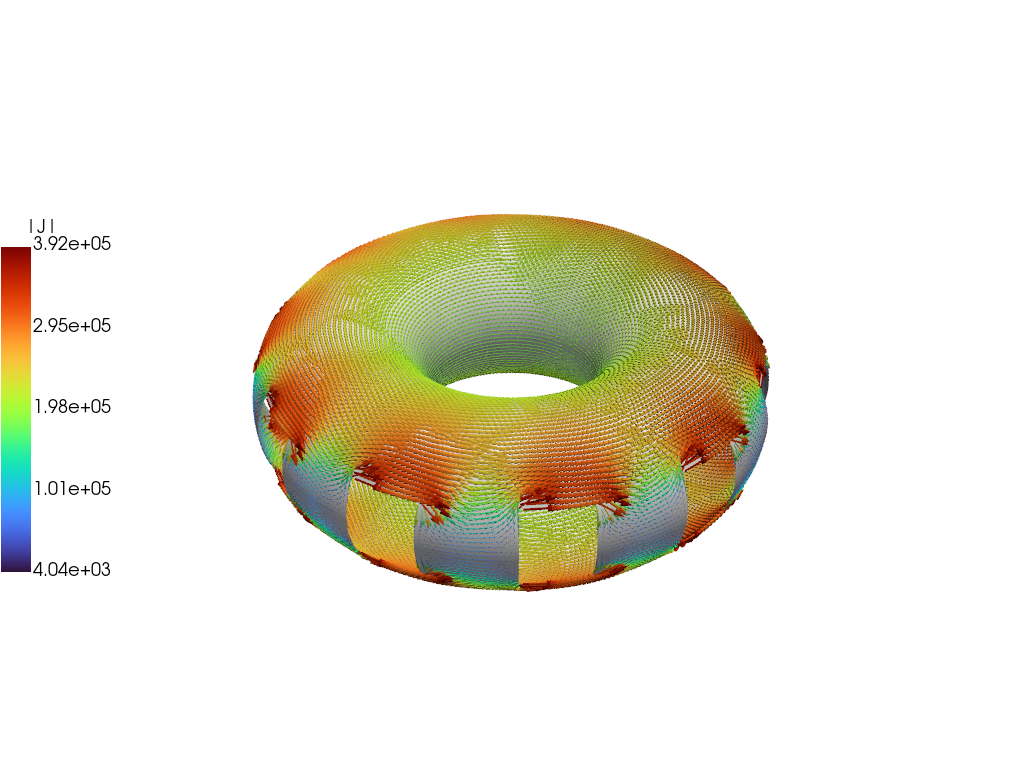

In [20]:
Jreduced = tw_torus.reconstruct_current(torus_reduced.reconstruct_potential(currents['curr'][10]),centering='vertex')
grid["vectors"] = Jreduced
grid.set_active_vectors("vectors")
p = pyvista.Plotter()
scale = 0.2/(np.linalg.norm(Jreduced,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "|J|", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.add_mesh(grid, color="white", opacity=1.0, show_edges=False)
p.show()

### Compare magnetic field
As with the current we can also compare the magnetic field between the full simulation and the reduced model, showing excellent visual agreement at $t = 20$ ms.

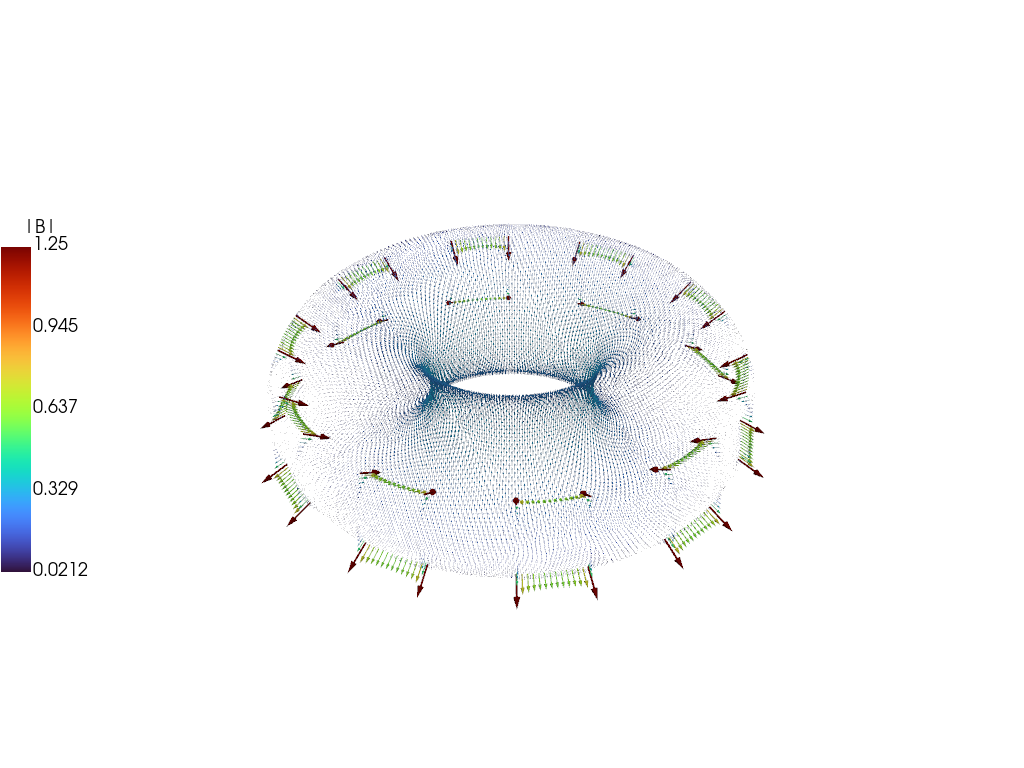

In [21]:
with h5py.File('vector_dump.0001.h5','r') as h5_file:
    Bfull = np.asarray(h5_file['B_v0011'])
#
grid["vectors"] = Bfull
grid.set_active_vectors("vectors")
p = pyvista.Plotter()
scale = 0.2/(np.linalg.norm(Bfull,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "|B|", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.show()

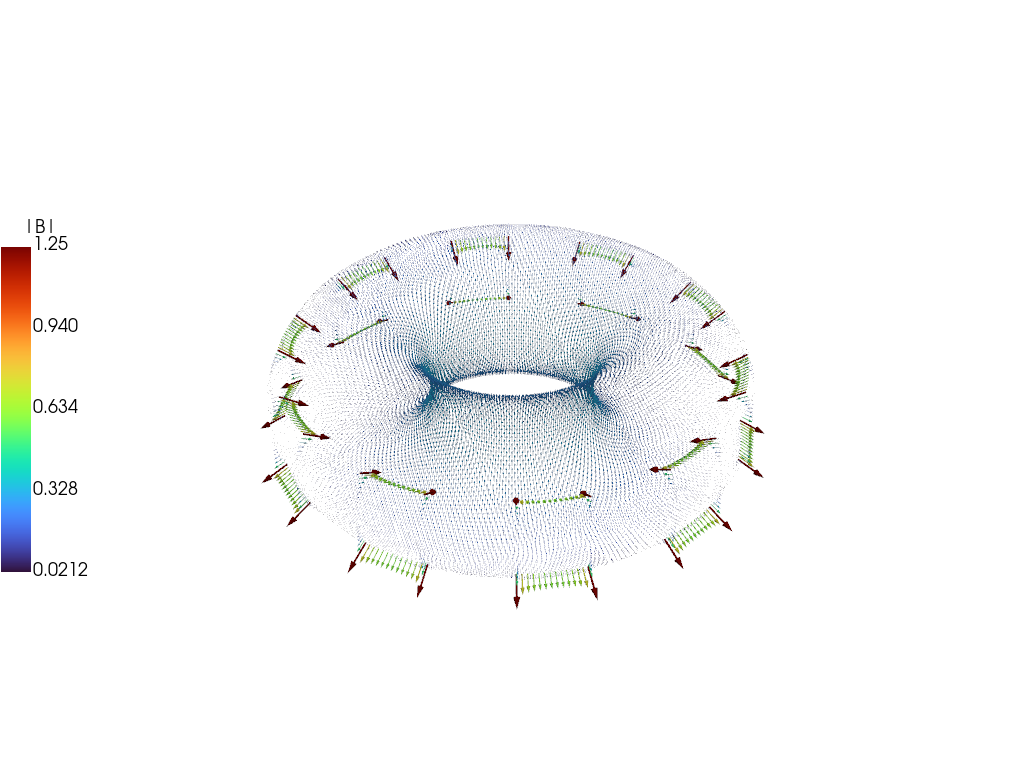

In [22]:
Breduced = torus_reduced.reconstruct_Bfield(currents['curr'][10],coil_currs=currents['coil_curr'][10])
grid["vectors"] = Breduced
grid.set_active_vectors("vectors")
p = pyvista.Plotter()
scale = 0.2/(np.linalg.norm(Breduced,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "|B|", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.show()

# Further model reduction

### Determine most active modes
To further reduce the model we can look at the output of the previous to determine which modes in the basis set are active in the chosen simulation. In this case, the vast majority of the energy in the system is contained in only the first 5 modes.

This makes sense as all the sources driving our system are axisymmetric (single circular current filament) and as a result we expect all the eigenstructures with toroidal mode number greater than zero to have very little coupling to this structure (ideally zero). Additionally, as the L/R system results in orthogonal eigenvectors we don't expect any coupling between modes themselves. This can be seen as all modes decay exponentially (linear on semilog plot) after the driving voltage drops to zero.

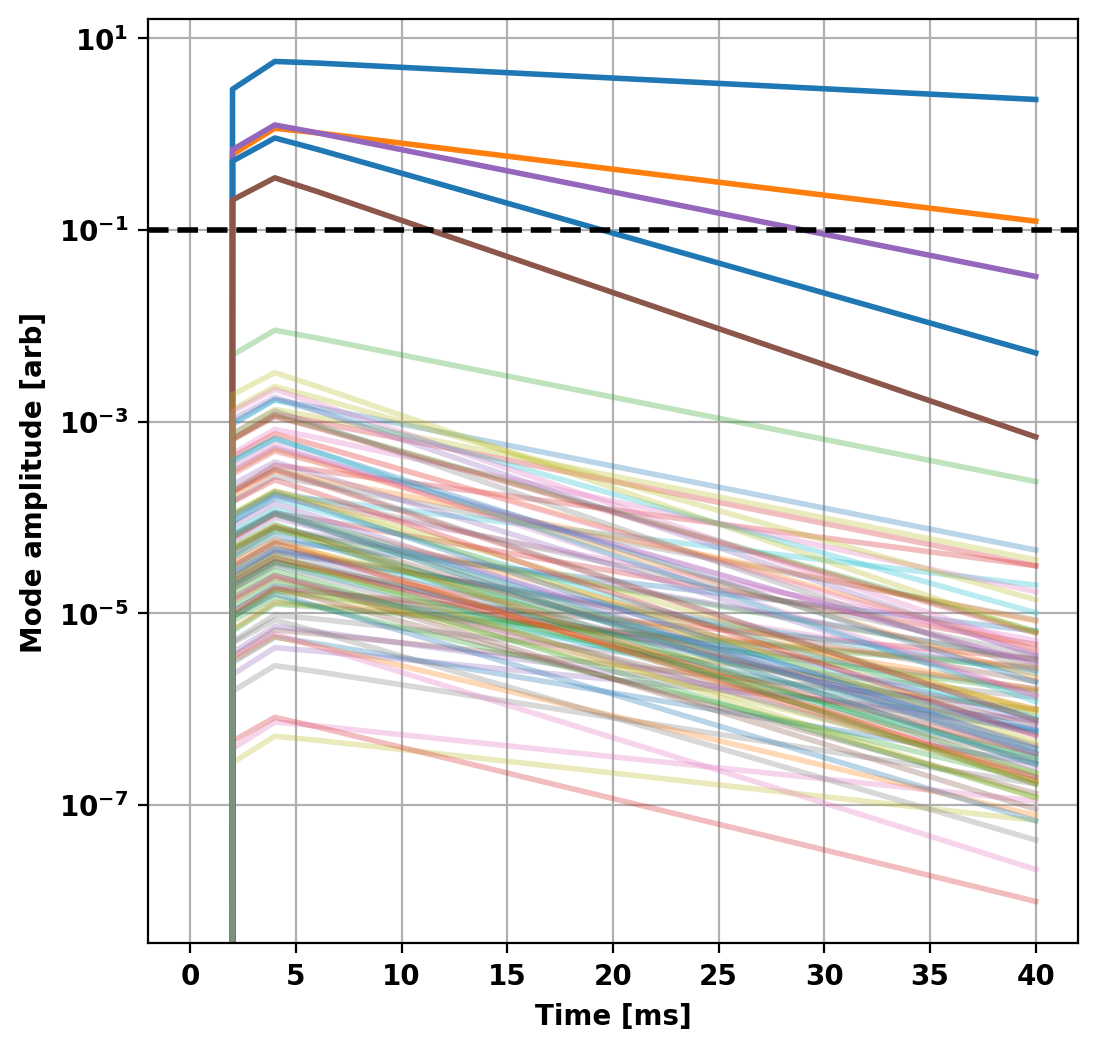

In [23]:
fig, ax = plt.subplots(1,1)
eig_inds = []
for i in range(currents['curr'].shape[1]):
    if abs(currents['curr'][:,i]).max() > 1.E-1:
        ax.semilogy(currents['time']*1.E3,abs(currents['curr'][:,i]))
        eig_inds.append(i)
    else:
        ax.semilogy(currents['time']*1.E3,abs(currents['curr'][:,i]),alpha=0.3)
ax.axhline(1.E-1,color='k',linestyle='--')
ax.grid(True)
ax.set_xlabel('Time [ms]')
_ =ax.set_ylabel('Mode amplitude [arb]')

## Repeat calculations with minimal model
We now repeat the eigenvalue and time-domain solves from above with the further reduced model.

**Note:** We have now reduced our system to only **200 Bytes** from > 3 GB (15,000,000x smaller)! Assuming we are only interested in axisymmetric slow dynamics of course.

In [24]:
torus_reduced_more = tw_torus.build_reduced_model(eig_vecs[eig_inds,:], compute_B=True, sensor_obj=sensor_obj)

### Compute and compare eigenvalues

In [25]:
eig_vals_r2, eig_vecs_r2 = torus_reduced_more.get_eigs()
print("  {0:12} {1:12} ({2:8})".format("Reduced","Original","% Error"))
for i, eig_val in enumerate(eig_vals_r2):
    print("{0:12.4E} {1:12.4E}   ({2:8.2E})".format(eig_val*1.E3,eig_vals[eig_inds[i]]*1.E3,abs((eig_val-eig_vals[eig_inds[i]])/eig_vals[eig_inds[i]])))

  Reduced      Original     (% Error )
  3.8804E+01   3.8804E+01   (4.32E-09)
  1.6008E+01   1.6008E+01   (2.66E-09)
  9.8463E+00   9.8463E+00   (1.84E-09)
  6.9472E+00   6.9472E+00   (1.86E-09)
  5.7673E+00   5.7673E+00   (7.24E-10)


### Run time-dependent simulation

In [26]:
sensors2, currents2 = torus_reduced_more.run_td(dt,nsteps,coil_currs)

Timestep 0   0.0000E+00   0.0000E+00
Timestep 10   2.0000E-03   3.1344E+00
Timestep 20   4.0000E-03   6.0592E+00
Timestep 30   6.0000E-03   5.7573E+00
Timestep 40   8.0000E-03   5.4154E+00
Timestep 50   1.0000E-02   5.1068E+00
Timestep 60   1.2000E-02   4.8245E+00
Timestep 70   1.4000E-02   4.5637E+00
Timestep 80   1.6000E-02   4.3210E+00
Timestep 90   1.8000E-02   4.0941E+00
Timestep 100   2.0000E-02   3.8811E+00
Timestep 110   2.2000E-02   3.6806E+00
Timestep 120   2.4000E-02   3.4915E+00
Timestep 130   2.6000E-02   3.3129E+00
Timestep 140   2.8000E-02   3.1440E+00
Timestep 150   3.0000E-02   2.9841E+00
Timestep 160   3.2000E-02   2.8327E+00
Timestep 170   3.4000E-02   2.6892E+00
Timestep 180   3.6000E-02   2.5531E+00
Timestep 190   3.8000E-02   2.4241E+00
Timestep 200   4.0000E-02   2.3017E+00


### Compare reduced models
First we compare the amplitude of each component (basis weight) of the two reduced models in time to show that they have the same behavior even with fewer modes in the system.

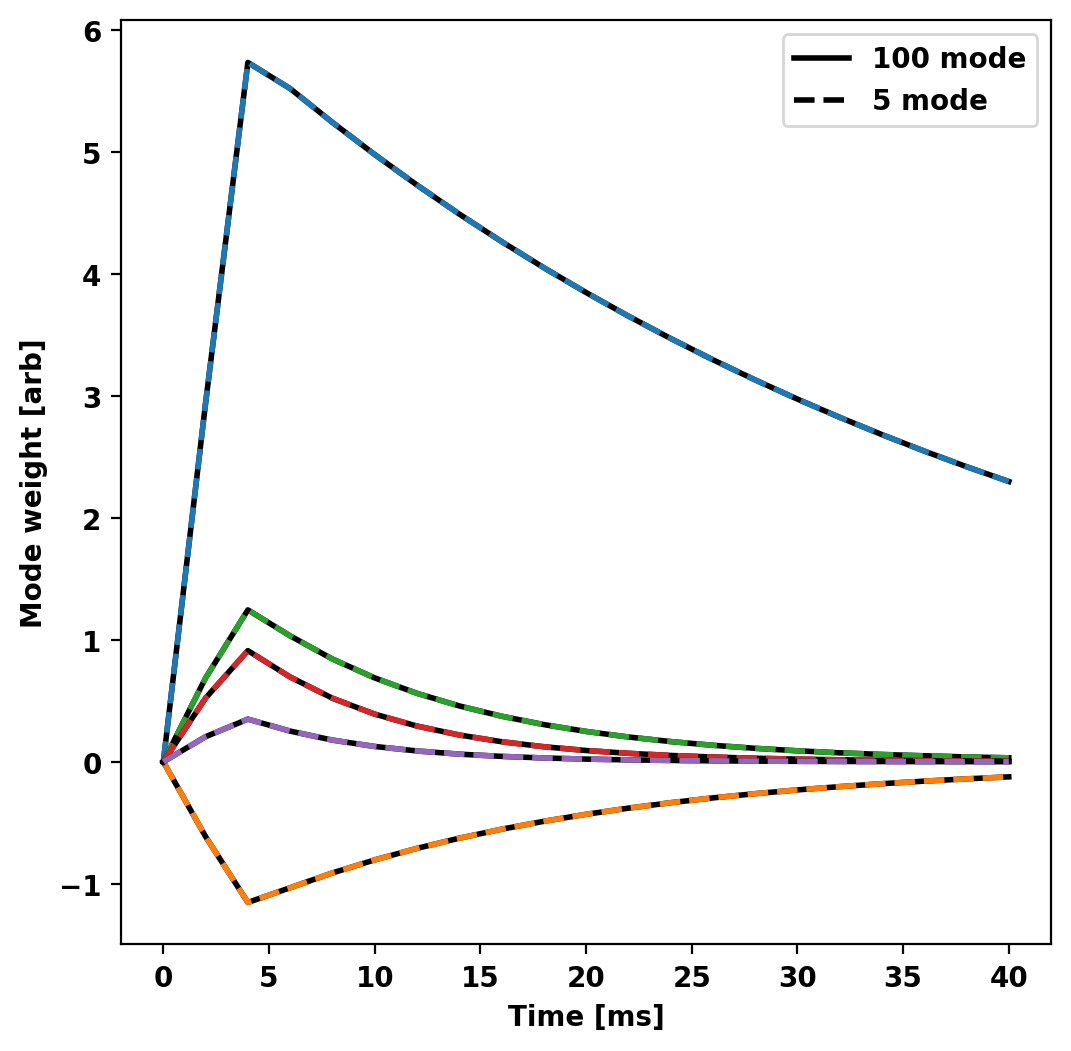

In [27]:
fig, ax = plt.subplots(1,1)
for i in range(currents2['curr'].shape[1]):
    line, = ax.plot(currents['time']*1.E3,currents['curr'][:,eig_inds[i]],'k')
    ax.plot(currents2['time']*1.E3,currents2['curr'][:,i],'--')
Full = mlines.Line2D([], [], color='k', linestyle='-',label='100 mode')
Reduced = mlines.Line2D([], [], color='k', linestyle='--',label='5 mode')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Mode weight [arb]')
_ = ax.legend(handles=[Full, Reduced])

Now we compare the probe signals from the two reduced models showing that the results overlay eachother.

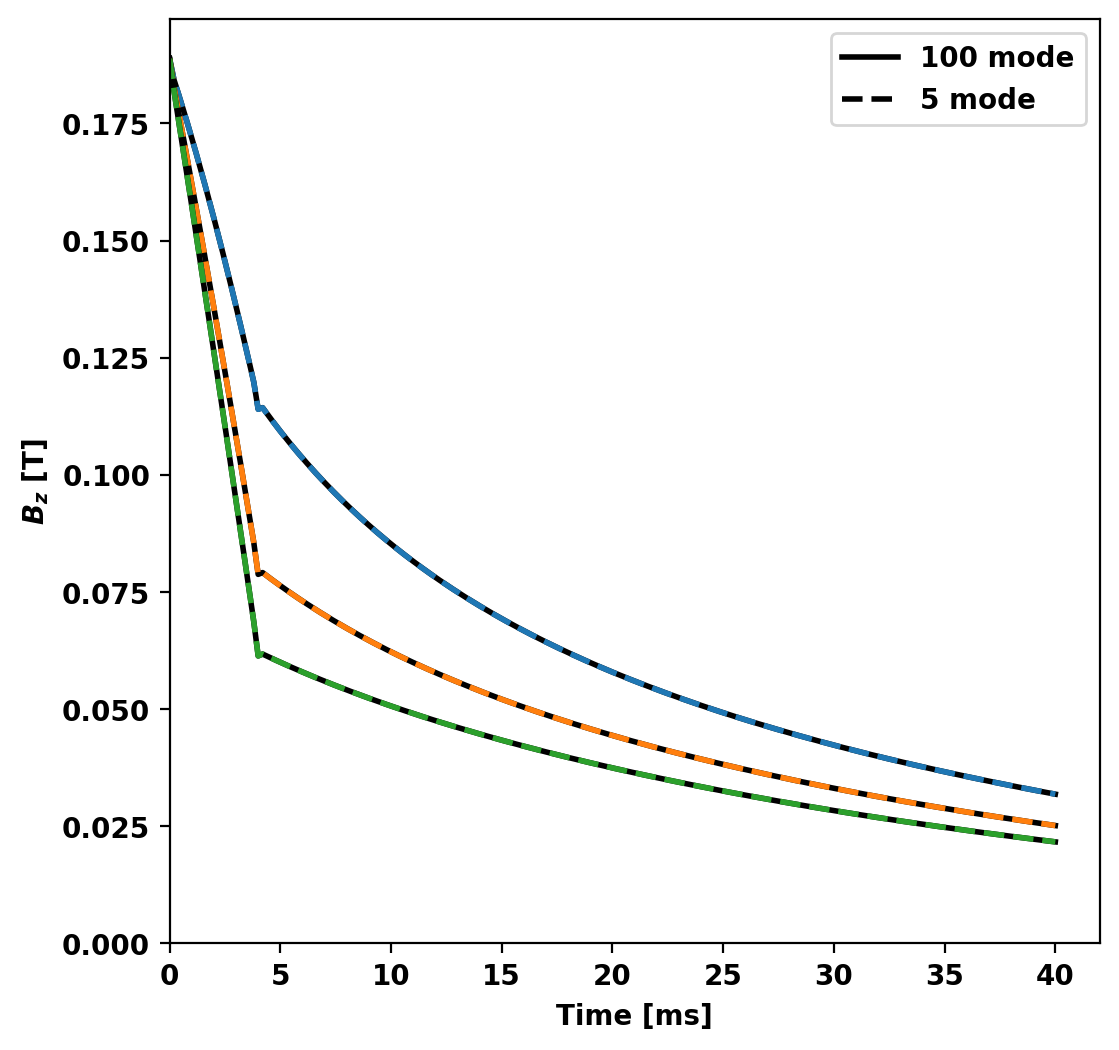

In [28]:
fig, ax = plt.subplots(1,1)
for i in range(sensors['sensors'].shape[1]):
    ax.plot(sensors['time']*1.E3,sensors['sensors'][:,i],'k')
    ax.plot(sensors2['time']*1.E3,sensors2['sensors'][:,i],'--')
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0)
Full = mlines.Line2D([], [], color='k', linestyle='-',label='100 mode')
Reduced = mlines.Line2D([], [], color='k', linestyle='--',label='5 mode')
ax.legend(handles=[Full, Reduced])
ax.set_xlabel('Time [ms]')
_ =ax.set_ylabel(r'$B_z$ [T]')